In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt

import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

from itertools import combinations
#%%capture  output
import itertools
from tqdm import tqdm


import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
from tensorflow import keras

from scipy import stats

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.Series(x.indices)
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]

def reclassify(s, reload_spectrum=False):
    if s is None:
        return None
    if reload_spectrum:
        s=wisps.Source(filename=s.name.replace('g141', 'G141'))
    #spt_unc=s.spectral_type[1
    #rngs=[[1.17,1.35],[1.45,1.67]]
    rngs=[[1.15, 1.65]]
    spt, spt_e= splat.classifyByStandard(s.splat_spectrum, fitrange=[[1.15, 1.65]], 
                                         sptrange=['M0','Y1'], average=True)
    #s.classify_by_standard(comprange=rngs)
    #print(wisps.make_spt_number(spt))
    #spt, spt_e=wisps.classify_by_templates(s, comprange=rngs)
    s.spectral_type=(np.round(wisps.make_spt_number(spt)), spt_e)
    s.calculate_distance(use_spt_unc=True, use_index_type=False)
    
    return s

def reclassify_by_templ(s):
    if s is None:
        return None
    #spt_unc=s.spectral_type[1
    #rngs=[[1.17,1.35],[1.45,1.67]]
    rngs=[[1.17, 1.67]]
    #spt, spt_e= splat.classifyByStandard(s.splat_spectrum, fitrange=[[1.15, 1.65]], 
    #                                     sptrange=['M0','Y1'], average=True)
    #s.classify_by_standard(comprange=rngs)
    #print(wisps.make_spt_number(spt))
    spt, spt_e=wisps.classify_by_templates(s, comprange=rngs)
    s.spectral_type=(np.round(wisps.make_spt_number(spt)), spt_e)
    s.calculate_distance(use_spt_unc=True, use_index_type=False)
    
    return s


In [3]:
def get_cands(by_templates=False,  reload_spectrum=False):
    #read in the data
    cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.hdf', key='all')
    if by_templates:
        spectra=[reclassify_by_templ(x) for x in cands0.spectra]
    else:
        spectra= [reclassify(x,  reload_spectrum= reload_spectrum) for x in tqdm(cands0.spectra)]
    cands0['spectra']=spectra
    cands=cands0.spectra.apply(get_indices)
    cands['spectra']=cands0.spectra
    cands['grism_id']=cands0.grism_id
    cands['spt']=cands0.spectra.apply(get_spt)
    canddf=cands[~cands.spectra.isna()].reset_index(drop=True)
    canddf['spt']=canddf.spectra.apply(lambda x: x.spectral_type[0])
    canddf['spt_er']=canddf.spectra.apply(lambda x: x.spectral_type[1])
    canddf['distance']=canddf.spectra.apply(lambda x: x.distance['val'].value)
    canddf['distance_er']=canddf.spectra.apply(lambda x: x.distance['er'].value)
    canddf['coord']=canddf.spectra.apply(lambda x:x.coords)
    canddf['designation']=canddf.spectra.apply(lambda x: x.designation)
    #canddf['index_type_er']=canddf.spectra.apply(lambda x: x.index_type[1])
    canddfj=canddf.join(canddf.spectra.apply(lambda x: pd.Series(x.mags)))
    canddff=canddfj.join(canddf.spectra.apply(lambda x: pd.Series(x.snr)))
    canddff['spectra']=canddf.spectra

    canddff=canddff.drop_duplicates('designation')
    #visuallty excluded
    exclude=list(set(['J01253527-0001383', 'J20220361-3113264', 
             'J05300520-0723374', 'J05315184-0723016',
             'J14313999+2447186', 'J15343866+5014150', 'J10044909+5258293',
             'J14193494+5256146', 'J15474619+2057475',
            'J10003065+0217017', 'J02170287-0513385', 
            'J12363034+6215023']))
    ucds=wisps.Annotator.reformat_table((canddff[(canddff.spt>=17) & \
                                                 (~(canddff.designation.str.upper().isin(exclude))) \
    ]).reset_index(drop=True)).sort_values(by='designation')
    #remove some objects by name
    ucds=(ucds[~ ucds.grism_id.isin(['par199-00124'])]).reset_index(drop=True).sort_values(by='spt')
    return ucds, canddff

In [4]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

In [5]:
#ucds=pd.read_pickle('~/research/wisps/libraries/real_ucds.pkl')
#selection objects 
#indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
#neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/conv_model_withspt_snr_september17.h5')

In [6]:
#neural_network

In [7]:
big=wisps.get_big_file()

In [8]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def select_by_indices(df, idx, spt_range):
    print(spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    _, bools= bx._select(np.array([df[idx.xkey].values, df[idx.ykey].values]))
    return bools
        

def apply_scale(x):
    ##remove nans 
    ##this is the same scaling used 
    ## same scaling used for 
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y


def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    #min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt', 'f_test', 'x']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #make predictions
    probs=rf.predict_proba(pred_df[features].values)
    labels=np.logical_or.reduce((
                                probs[:,1]>0.5,\
                                probs[:, 2] >0.5, \
                                 probs[:,3] >.5 ,\
                                 probs[:,4] >0.5, \
                                 probs[:,5] >0.5))
    
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
    #labels=rf.predict(pred_df[features].values)
 
    return {'probs': probs, 'labels': labels}



def select_by_neuralnet(df):
    #define features (start with indices alone)
    #apply logs to problematic features the same way I did on my classification
    features=rfdict['feats']
    
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #probs= neural_network.predict(  pred_df[features].values)
    #need to reshape
    #probs=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    
    #my cuts
    #labels=np.logical_or.reduce((probs[:, 2] > .7, probs[:,3] >.5 , probs[:,4] >0.5))
    #labels=probs[:,0] <0.5
    #labels=neural_network.predict_classes(  pred_df[features].values.reshape(-1, len(features), 1))
    #labels=neural_network.predict(  pred_df[features].values.reshape(-1, len(features), 1))
    probs= neural_network(  pred_df[features].values, training=False)
    labels=np.logical_or.reduce((
                                probs[:,1]>0.5,\
                                probs[:, 2] >0.5, \
                                 probs[:,3] >.5 ,\
                                 probs[:,4] >0.5, \
                                 probs[:,5] >0.5))
    
    #labels=np.logical_or.reduce([probs[:, 1]>0.9, labels ])
    #labels=neural_network.predict_classes(  pred_df[features].values)
    #labels=np.logical_or.reduce([ probs[:, 0]<0.05, labels ])
 
    return {'probs': probs, 'labels': labels}



In [9]:
def ucd_selection_method(ro):
    select=''
    if ro.index_label:
        select +="Indices, "
    if ro.selected_by_nn:
        select +="DNN, "
    if ro.selected_by_rf:
        select +="RF "
    if select.endswith(', '):
        select=select.replace(',', '')
    return select

In [10]:
def label_ucds(ucds):
    ucds['x']=ucds.spectra.apply(lambda x: x.spex_chi/x.line_chi)
    ucds['line_chi']=ucds.spectra.apply(lambda x: x.line_chi)
    ucds['spex_chi']=ucds.spectra.apply(lambda x: x.spex_chi)
    ucds['f_test']=ucds.spectra.apply(lambda x: x.f_test)
    ls=select_by_neuralnet(ucds)
    rf_ls= select_by_random_forest(ucds)
    #add labels for index selection
    ucds['selected_by_rf']=rf_ls['labels']
    ucds['selected_by_nn']=ls['labels']
    
    
    for idxk, k in indices_to_use:
        idx=slc_crts[idxk]
        ucds['selected_by_{}'.format(k)]= select_by_indices(ucds, idx, k)
        
    ucds['index_label']=np.logical_or.reduce([ucds['selected_by_{}'.format(x)].values 
                                                  for x in  np.vstack(indices_to_use)[:,1]])
    #make that colormap
    ucds['selection']=ucds.apply(ucd_selection_method, axis=1).values
    return ucds

In [11]:
def formatted_distance(x):
    d= str(int(round(np.nan_to_num(x.distance['val'].value), 0)))
    der=[str(int(abs(round(np.nan_to_num(x.distance['er'].value[0]), 0)))),\
            str(int(abs(round(np.nan_to_num(x.distance['er'].value[1]), 0))))]
         
    if abs(x.distance['er'].value[0])/x.distance['val'].value >1.0:
        der=[str(x.distance['er'].value[0]), str(x.distance['er'].value[1])]
        #return "$\\approx$"+d
        return d+'$^{+'+der[0]+'}'+'_{-'+der[1]+'}$'
    else:
        return d+'$^{+'+der[0]+'}'+'_{-'+der[1]+'}$'
        #return r'$'+d+'\substack{+'+der[0]+'\\\ -'+der[-1]+'}$'
    #return d+'$^{+'+der[0]+'}'+'_{-'+der[1]+'}$'

In [12]:
def latex_version(ucds, additional_cols=[]):
    #missed_bools=(ucds.selection=='').values
    labelled=wisps.Annotator.group_by_spt(ucds, spt_label='spt', assign_number=False)

    #for idxk, k in indices_to_use:
    #    idx=slc_crts[idxk]
    #    labelled['selected_by_{}'.format(k)]= select_by_indices(labelled, idx, k)

    #labelled['index_label']=np.logical_or.reduce([labelled['selected_by_{}'.format(x)].values 
    #                                              for x in  np.vstack(indices_to_use)[:,1]])
    fdf=ucds
    latc_df=pd.DataFrame()
    latc_df['Shortname']=fdf.spectra.apply(lambda x: x.shortname.upper())
    latc_df['designation']=fdf.spectra.apply(lambda x: x.designation.upper())
    latc_df['grism id']=fdf.spectra.apply(lambda x: x.name.upper().replace('_', '-'))
    latc_df['snrj']=fdf.spectra.apply(lambda x: int(round(x.snr['snr1'])))
    latc_df['spt']=fdf.spectra.apply(lambda x: splat.typeToNum(x.spectral_type[0]) +r'$\pm$'+ str(round(x.spectral_type[1], 1)))
    latc_df['ra']=fdf.spectra.apply(lambda x: x.ra.value)
    latc_df['dec']=fdf.spectra.apply(lambda x: x.dec.value)
    latc_df['f110']=fdf.spectra.apply(lambda x:  str(round(x.mags['F110W'][0],3)) +r'$\pm$'+ str(round(x.mags['F110W'][1],3)))
    #latc_df['f110_er']=fdf.spectra.apply(lambda x: round(x.mags['F110W'][1], 1))
    latc_df['f140']=fdf.spectra.apply(lambda x:  str(round(x.mags['F140W'][0],3)) +r'$\pm$'+  str(round(x.mags['F140W'][1],3)))
    #latc_df['f140_er']=fdf.spectra.apply(lambda x: round(x.mags['F140W'][1], 1))
    latc_df['f160']=fdf.spectra.apply(lambda x:   str(round(x.mags['F160W'][0],3)) + r'$\pm$'+ str(round(x.mags['F160W'][1],3)))
    #latc_df['f160_er']=fdf.spectra.apply(lambda x: round(x.mags['F160W'][1], 1))
    latc_df['distance']=fdf.spectra.apply(formatted_distance)
    latc_df['Selected By']= fdf['selection']
    latc_df=latc_df.replace('nan$\\pm$nan', '\nodata')
    return latc_df

In [13]:
EXPORT_DIR=wisps.OUTPUT_FILES+'/deep_model_july17_2021_min_entropy.h5'
neural_network = keras.models.load_model(EXPORT_DIR, custom_objects={"get_f1": get_f1},\
                                   compile=False)
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier_plusys_july172021.pkl')
import wisps.data_analysis.selection_criteria as sel_crt
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
slc_crts=sel_crt.crts_from_file()#the classifier 


In [14]:
#ucds=get_cands(by_templates=False)
#stick itht the current sample no more addition
ucds=pd.read_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')
ucds=label_ucds(ucds)
ucds=ucds[ucds.selection !='']
len(ucds)

M7-L0
L0-L5
L5-T0
T0-T5
T5-T9
Y dwarfs
subdwarfs


164

In [15]:
#ucds_by_templates=get_cands(by_templates=True)


In [16]:
#ucds_missed=ucds_by_templates[~ucds_by_templates.designation.isin(ucds.designation)]

In [17]:
def classsify_by_standard_only(s):
    spt, spt_e= splat.classifyByStandard(s.splat_spectrum, fitrange=[[1.15, 1.65]], 
                                         sptrange=['M0','Y1'], average=True)
    return spt, spt_e

In [18]:
#old_classification=ucds_missed.spectra.apply( classsify_by_standard_only)
#ucds_missed['spt_by_standard']=np.vstack(old_classification)[:,0]
#ucds_missed['spt_er_by_standard']=np.vstack(old_classification)[:,1]

In [19]:
#ucds_missed=label_ucds(ucds_missed.reset_index(drop=True))
#ucds_missed=ucds_missed[ucds_missed.selection!='']

In [20]:
#indices_to_use

In [21]:
#ucds.grism_id=ucds.grism_id.str.lower()
#ucds=ucds[ucds.snr1>=3]
#big.grism_id=big.grism_id.str.lower()

In [22]:
#labeld_df=latex_version(ucds)

In [23]:
#labeld_df=labeld_df.sort_values('designation')

In [24]:
#labeld_df

In [25]:
#len(ucds), len(labeld_df)

In [26]:
#ucds

In [27]:
#assert len(labeld_df)==len(ucds)

In [28]:
col_list=['designation','grism id', 'f110', 'f140', 'f160', \
          'snrj', 'spt', 'distance','Selected By']
add_colist=['designation','grism id', 'f110', 'f140', 'f160', \
          'snrj', 'spt', 'spt_std', 'distance','Selected By']

In [29]:
#cands_missed_latex_version=(latex_version(ucds_missed))[col_list]

In [30]:
def format_missed_spt(spt, spter):
    return spt.replace('.0:', '.0') +r'$\pm$'+ str(np.round(spter, 1))

In [31]:
#

In [32]:
#cands_missed_latex_version['spt_std']=[format_missed_spt(x, y) for x, y in  zip(ucds_missed.spt_by_standard.values, \
#                             ucds_missed.spt_er_by_standard.values.astype(float))]

In [33]:
#cands_missed_latex_version[add_colist].sort_values(by='designation').to_latex('/users/caganze/research/wisps/libraries/candidates_missed.tex',
#             header=True, index=False, escape=False, na_rep=' ')

In [34]:
#

In [35]:
#mlabeld_df_mask=labeld_df.spt.str.startswith('M').values

In [36]:
#labeld_df[col_list][mlabeld_df_mask].to_latex('/users/caganze/research/wisps/libraries/candidates_m.tex',
#             header=True, index=False, escape=False, na_rep=' ')
                    
#labeld_df[col_list][~mlabeld_df_mask].to_latex('/users/caganze/research/wisps/libraries/candidates_lt.tex',
#             header=True, index=False, escape=False, na_rep=' ')

In [37]:
#ucds.selection.values

In [38]:
#ucds=pd.read_pickle(wisps.LIBRARIES+'/new_real_ucds.pkl')

In [39]:
selection_table={}
selection_table['rf']={}
selection_table['nn']={}
selection_table['indices']={}

In [40]:
labelled=ucds

In [41]:
def relabel_spectral_range(spt):
    if (spt>=17) & (spt<= 19):
        return 'M7-L0'
    if (spt>=20) & (spt<= 24):
        return 'L0-L5'
    if (spt>=25) & (spt<= 29):
        return 'L5-T0'
    if (spt>=30) & (spt<= 34):
        return 'T0-T5'
    if (spt>=34) & (spt<= 39):
        return 'T5-Y0'

In [42]:
labelled['spt_range']=labelled.spt.apply(relabel_spectral_range)

In [43]:


#rfselection=pd.read_csv(wisps.OUTPUT_FILES+'/selected_by_rf.csv')
#nnres=pd.read_pickle(wisps.OUTPUT_FILES+'/deep_neural_net_classifier_results.pkl')

#rfselection.shape

#nnsel= pd.concat(nnres['selected'])

nnselection =pd.DataFrame()
rfselection=pd.DataFrame()

#nnselection['grism_id']=ucds.grism_id[ls['labels']]
#rfselection['grism_id']= ucds.grism_id[rf_ls['labels']]
#nnselection=nnselection.drop_duplicates('grism_id')




for g in labelled.groupby('spt_range'):
    df0=g[1]
    print ('{}'.format(g[0]))
    print ('selected by rf {}'.format(len(df0[df0.selected_by_rf])))
    print ('selected by NN {}'.format(len(df0[df0.selected_by_nn])))
    print ('selected by indices {}'.format(len(df0[df0.index_label])))
    selection_table['rf'][g[0]]=len(df0[df0.selected_by_rf])
    selection_table['nn'][g[0]]=len(df0[df0.selected_by_nn])
    selection_table['indices'][g[0]]=len(df0[df0.index_label])
    #print ('selected by rf or indices {}'.format(len(df0[np.logical_or(df0.index_label,df0.selected_by_rf) ])))
    #print ('selected by NOT rf and indices {}'.format(len(df0[np.logical_and(df0.index_label,~df0.selected_by_rf) ])))
    #print ('selected by rf and NOT indices {}'.format(len(df0[np.logical_and(~df0.index_label,df0.selected_by_rf) ])))
    #print ('selected by NN or indices {}'.format(len(df0[np.logical_or(df0.index_label,df0.selected_by_nn) ])))
    #print ('selected by NOT NN and indices {}'.format(len(df0[np.logical_and(df0.index_label,~df0.selected_by_nn) ])))
    #print ('selected by NN and NOT indices {}'.format(len(df0[np.logical_and(~df0.index_label,df0.selected_by_nn) ])))
    #print ('---------------------------------------------------------------- ')

L0-L5
selected by rf 21
selected by NN 19
selected by indices 21
L5-T0
selected by rf 5
selected by NN 5
selected by indices 5
M7-L0
selected by rf 120
selected by NN 124
selected by indices 125
T0-T5
selected by rf 7
selected by NN 7
selected by indices 7
T5-Y0
selected by rf 3
selected by NN 3
selected by indices 3


In [44]:
labelled.selected_by_nn.sum()

158

In [45]:
labelled.selected_by_rf.sum()

156

In [46]:
labelled.index_label.sum()

161

In [47]:
len(ucds[ucds.spt.between(17, 19)]), \
len(ucds[ucds.spt.between(20, 29)]),  \
len(ucds[ucds.spt.between(30, 39)]),\
len(ucds)

(128, 26, 10, 164)

In [48]:
labelled[np.logical_and(labelled.selected_by_nn, ~labelled.index_label)].spt

144    17.0
48     17.0
43     18.0
Name: spt, dtype: float64

In [49]:
labelled[np.logical_and(labelled.selected_by_rf, ~labelled.index_label)].spt

144    17.0
48     17.0
Name: spt, dtype: float64

In [50]:
len(ucds[ucds.spt.between(17, 19)]), \
len(ucds[ucds.spt.between(20, 24)]),  \
len(ucds[ucds.spt.between(25, 29)]),\
len(ucds[ucds.spt.between(30, 34)]),\
len(ucds[ucds.spt.between(35, 39)]),\
len(ucds)

(128, 21, 5, 7, 3, 164)

In [51]:
real_probs_rf=select_by_random_forest(ucds)

In [52]:
def ucds_real_labels(spt_range):
    
    if spt_range =='M7-L0':
        return 1
    if spt_range.startswith('L'):
        return 2
    if spt_range.startswith('T'):
        return 3
    

In [53]:
real_labels= ucds.spt_range.apply( ucds_real_labels)

In [54]:
lp=select_by_neuralnet(big)

In [55]:
rf_lp=select_by_random_forest(big)

In [56]:
len(rf_lp['labels'])

254264

In [57]:
np.shape(rf_lp['probs'][ big.mstar_flag.astype(bool)])

(46561, 6)

In [58]:
#previous best-fit model
rf=rfdict['classifier']
features=np.array([r'H$_2$O-1/J-Cont', r'H$_2$O-2/H$_2$O-1', r'$H-cont/H$_2$O-1$', \
                   r'CH$_4$/H$_2$O-1', r'H$_2$O-2/J-Cont',r'H-cont/J-Cont', r'CH$_4$/J-Cont', \
                   'H-cont/$H_2O-2$', r'CH$_4$/H$_2$O-2', r'CH$_4$/H-Cont', r'H$_2$O-1+H$_2$O-2/J-Cont',
                   r'H$_2$O-1+H$_2$O-2/H-Cont', r'H$_2$O-1+CH$_4$/J-Cont', r'H$_2$O-2+CH$_4$/J-Cont',
                   r'H$_2$O-1+CH$_4$/H-Cont', r'H$_2$O-2+CH$_4$/H-Cont', 'SpT',  r'$\chi_T^2/\chi_L^2$', 'F-test', 'J-SNR',\
                   'JH-SNR', 'H-SNR', 'Median-SNR'])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


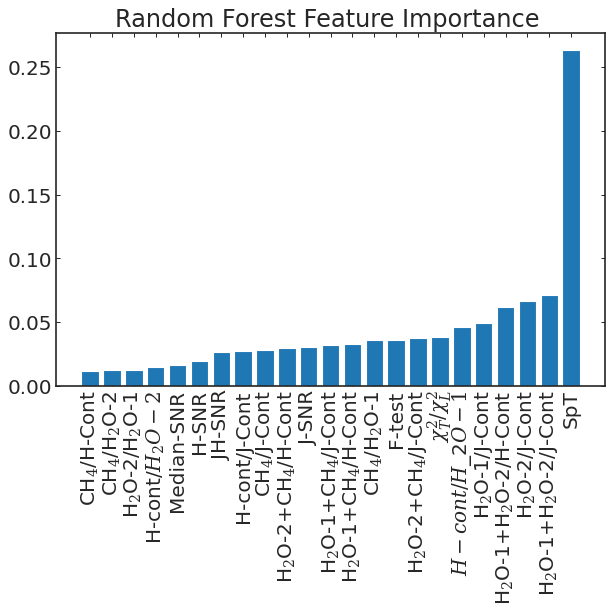

In [59]:
###--------------------------------------------
fig, ax=plt.subplots(figsize=(8, 8))

feature_names=features
tree_feature_importances = (
    rf.feature_importances_)
    
sorted_idx = tree_feature_importances.argsort()

x_ticks = np.arange(0, len(feature_names))
ax.bar(x_ticks, tree_feature_importances[sorted_idx])
ax.set_xticklabels(feature_names[sorted_idx], rotation='vertical')
ax.set_xticks(x_ticks)
ax.set_title("Random Forest Feature Importance ")
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/rffeatureimportance.pdf', bbox_inches='tight')

In [60]:
colors=['#111111', '#FF4136', '#FF851B', '#B10DC9', '#39CCCC','#0074D9']
classes=['CTM', r'M7-M9', 'L', 'T', 'Y', 'Sd']
len(classes)

6

In [61]:
#for idx in np.arange(6):
#    plt.hist(wisps.drop_nan(np.log10(lp['probs'][ big.mstar_flag.astype(bool).values][:,idx])))

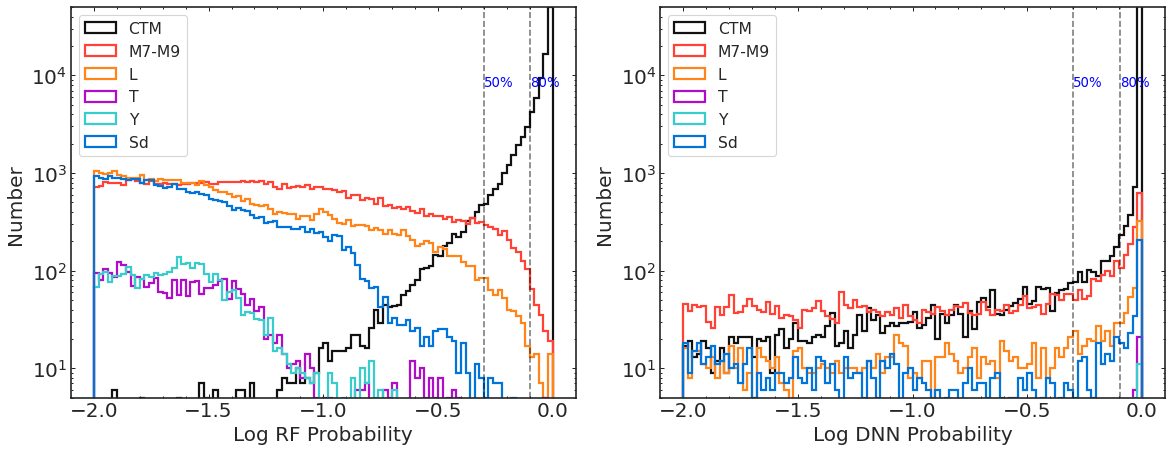

In [91]:
fig, ax=plt.subplots(ncols=2, figsize=(10*1.5, 4*1.5))
for idx in np.arange(0,6):
    _ = ax[0].hist(wisps.drop_nan(np.log10(rf_lp['probs'][ (big.class_star !=0).values][:,idx])), \
                histtype='step', bins=100, color=colors[idx],\
                   label=classes[idx], cumulative=False, density=False, log=True, lw=2,
                  range=[-2, 0])
    _= ax[1].hist(wisps.drop_nan(np.log10(lp['probs'][  (big.class_star !=0).values][:,idx])), \
              histtype='step',bins=100, color=colors[idx], label=classes[idx],\
                  cumulative=False, density=False, log=True, lw=2, range=[-2, 0])
    
for a in ax:
    a.set( ylabel='Number ', ylim=[5, 0.5e5])
    a.legend(fontsize=14, loc='upper left')
    a.minorticks_on()
    a.axvline(np.log10(0.8), linestyle='--', color='k', alpha=0.5)
    a.axvline(np.log10(0.5), linestyle='--', color='k', alpha=0.5)
    a.text(np.log10(0.8), 1e4, '80%', verticalalignment='top', c='b', fontsize=12)
    a.text(np.log10(0.5), 1e4, '50%', verticalalignment='top', c='b', fontsize=12)
ax[0].set(xlabel='Log RF Probability')
ax[1].set(xlabel='Log DNN Probability')
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mlprobabilities.pdf', bbox_inches='tight')

In [93]:
len(big[big.mstar_flag.astype(bool)]), len(big)

(46561, 254264)

In [63]:
len(big[(big.snr1>=3.0) & (rf_lp['labels']) & big.mstar_flag.astype(bool)])

550

In [64]:
len(big[(big.snr1>=3.0) & lp['labels'] &   big.mstar_flag.astype(bool) ])

753

In [65]:
len(big[big.mstar_flag.astype(bool)]), len(big[~big.mstar_flag.astype(bool)])

(46561, 207703)

In [66]:
len(ucds)

164

In [67]:
import astropy.units as u
0.3*(u.arcmin**-2).to(u.deg**-2)

1080.0000000000002

In [68]:
nn_select_bool= np.logical_and.reduce([big.mstar_flag.astype(bool), lp['labels'], \
                                       big.snr1>3 ])
rf_select_bool= np.logical_and.reduce([big.mstar_flag.astype(bool), rf_lp['labels'], \
                                       big.snr1>3 ])

In [69]:
nn_select_bool

array([False, False, False, ..., False, False, False])

In [70]:
np.shape(lp['probs'][nn_select_bool]), np.shape(lp['probs'])

(TensorShape([753, 6]), TensorShape([254264, 6]))

In [71]:
np.shape(rf_lp['probs'][rf_select_bool]), np.shape(rf_lp['probs'])

((550, 6), (254264, 6))

In [72]:
nnlbls=np.argmax(lp['probs'][nn_select_bool], axis=1)
len(nnlbls[nnlbls==5])

224

In [73]:
rflbls=np.argmax(rf_lp['probs'][rf_select_bool], axis=1)
len(rflbls[rflbls==5])

28

In [74]:
len(ucds[ucds.grism_id.str.lower().str.startswith('par')])

113

In [75]:
#h=plt.hist(np.argmax(lp['probs'][nn_select_bool], axis=1))

In [98]:
#resave this one object
s=ucds[ucds.designation =='J01101162-0225003'].spectra.values[0]

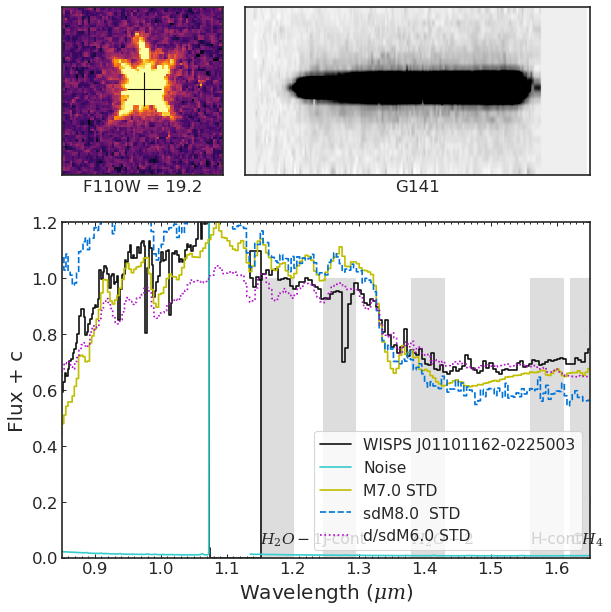

In [104]:
#replot one of the UCDS
s.plot(compare_to_sds=True, comprange=[[1.2, 1.65]], \
      save=True, filename='/Users/caganze/research/wisps/figures/ltwarfs/spectrum3.pdf')

In [76]:
jhj

NameError: name 'jhj' is not defined

In [ ]:
ucds, cds=get_cands(by_templates=False,  reload_spectrum=False)

In [ ]:
vls=wisps.Annotator.reformat_table(cds)[['spt', 'spt_er',
       'distance', 'distance_er', 'coord', 'designation', 'F110W', 'F110W_er',
       'F160W', 'F160W_er', 'F140W', 'F140W_er', 'grism_id']]

In [ ]:
vls['ra']=vls.coord.apply(lambda x: x.ra.degree)
vls['dec']=vls.coord.apply(lambda x: x.dec.degree)

In [ ]:
vls[['ra', 'dec', 'F110W', 'F110W_er', 'F160W', 'F160W_er','F140W', 'F140W_er',\
     'designation', 'grism_id']].to_csv('~/caganze_masterlist_deepfieldBDs.txt', \
                                         sep=' ')

In [ ]:
log J-SNR0 -a*m0=c

In [ ]:
def jsnr0(c, a, m0):
    return (c-(a*m0))

In [ ]:
abcs=[(-0.22, 0.17, 5.6), (-0.24, 0.10, 6.1), (-0.23, 0.17, 5.9 )]
m0s=[19.6, 19.8, 18.6]

In [ ]:
for m0, abc in zip(m0s, abcs):
    print ( jsnr0(abc[-1], abc[1], m0))